# Phrases

Process the phrases that appear in a relation.

## 1. Preprocess data

In [1]:
import copy
import datetime
import json
import pandas as pd
import re

In [2]:
def read_data(file_name):
    json_data = []
    infile = open(file_name, "r")
    for line in infile:
        json_data.append(json.loads(line))
    infile.close()
    
    return json_data

In [3]:
def combine_data(json_data):
    combined_data = {}
    for data in json_data:
        key = f"{data['source_id']} {data['speech_id']} {data['paragraph_id']}"
        if key not in combined_data:
            combined_data[key] = copy.deepcopy(data)
        else:
            if len(data["data"]) != len(combined_data[key]["data"]):
                print("cannot happen")
            for label_data in data["label"]:
                if label_data not in combined_data[key]["label"]:
                    combined_data[key]["label"].append(label_data)
                    if combined_data[key]["label"][-1][1] > len(combined_data[key]["data"]):
                        combined_data[key]["label"][-1][1] = len(combined_data[key]["data"])
    for key in combined_data:
        for label_data in combined_data[key]["label"]:
            label_data.append(combined_data[key]["data"][label_data[0]:label_data[1]])
    return combined_data

In [4]:
def tokenize(combined_data):
    for data_key in combined_data:
        paragraph = combined_data[data_key]["data"]
        tokens = {}
        token_id = -1
        for i in range(0, len(paragraph)):
            if token_id < 0 and paragraph[i] == " ":
                next
            elif token_id < 0:
                token_id = i
                tokens[token_id] = paragraph[i]
            elif paragraph[i] == " ":
                token_id = -1
            elif re.search("[.,?!]", paragraph[i]):
                tokens[i] = paragraph[i]
            else:
                tokens[token_id] += paragraph[i]
        labels = {}
        for label_key in tokens:
            labels[label_key] = "O"
        for label in combined_data[data_key]["label"]:
            if label[2] == 'Content_Concept_1' or label[2] == 'Content_Concept_2':
                for label_key in labels:
                    if label_key >= label[0] and label_key < label[1]:
                        labels[label_key] = "C"
            elif label[2] == 'Content_Relation_Explanation':
                for label_key in labels:
                    if label_key >= label[0] and label_key < label[1]:
                        labels[label_key] = "E"
        combined_data[data_key]["tokens"] = [ (tokens[label_key], labels[label_key]) for label_key in labels ]
    return combined_data

In [5]:
json_data = read_data("../data/femke-20211012.jsonl")
combined_data = combine_data(json_data)
combined_data = tokenize(combined_data)

## 2. Visualize data

In [6]:
def make_ids(labels, text):
    ids = {}
    for label_data in labels:
        while text[label_data[0]] in " .,?!:;":
            label_data[0] += 1
        while text[label_data[1]-1] in " .,?!:;":
            label_data[1] -= 1
        if label_data[0] in ids or label_data[1] in ids:
            print(f"overlapping relation parts! {data_item['label']}")
        ids[label_data[0]] = { "type": "start", "label": label_data[2] }
        ids[label_data[1]] = { "type":"end", "label": label_data[2] }
    return ids 

In [7]:
def add_colors_to_text(text, ids):
    for key in sorted(ids.keys(), reverse=True):
        if ids[key]["type"] == "end":
            text = text[:key+1] + "\x1b[m" + text[key+1:]
        else:
            if ids[key]["label"] == "Content_Concept_1":
                color_code = 1
            elif ids[key]["label"] == "Content_Concept_2":
                color_code = 4
            elif ids[key]["label"] == "Content_Relation_Explanation":
                color_code = 0
            else:
                color_code = 7
                print(f"unknown relation part label! ({ids[key]['label']})")
            text = text[:key] + f"\x1b[1;3{color_code};47m" + text[key:]
    return text    

In [8]:
def visualize(json_data, i):
    text = json_data[i-1]["data"]
    ids = make_ids(json_data[i-1]['label'], text)
    text = add_colors_to_text(text, ids)
    print(text + "\n")

In [9]:
MAX_PARAGRAPHS = 3

seen = {}
for i in range(1, len(json_data)+1):
    data_item = json_data[i - 1]
    if str(data_item["source_id"]) + " " + str(data_item["speech_id"]) in seen:
        continue
    visualize(json_data, i)
    seen[ str(data_item["source_id"]) + " " + str(data_item["speech_id"]) ] = True
    if MAX_PARAGRAPHS > 0 and len(seen) >= MAX_PARAGRAPHS:
        break

Today I want to send a clear message to the people of this great country, of Greece. I know that many people feel without hope. Many are making extremely difficult sacrifices. And many people ask why they should do more. I understand those concerns. And I agree that some of the efforts seem unfair. But I ask people to recognise the other alternatives which will be much more difficult for Greece and will affect even more the most vulnerable in the Greek society. So this is why it is the right approach to ask Greece to reform, to increase its competitiveness to have a viable future, irrespective of the crisis. You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece. And the best hope of a return to growth and job creation is inside the euro area. Staying in the euro is the best chance to avoid worse hardship and difficulties to the Greek people, namely for those in a more vulnerable posit

In [10]:
visualize(json_data, 1397)

Before EMU, the current euro area countries followed different economic strategies. Between 1970 and 1999, unit labour costs in Germany, the Netherlands en Austria grew by a factor of 2.5 to 3. During these 28 years prior to EMU, unit labour costs grew by a factor of 12 in Italy, 14 in Spain, 35 in Portugal and 55 in Greece. By regularly devaluing their currencies, these countries were able to restore competitiveness. But after the launch of EMU, this policy option was no longer available, of course.



## 3. Check for duplicate candidate phrases

Difficult cases:
* 22 (This)
* 363 (ex)
* 988 (:)
* 993 (:)

In [11]:
counter = 0
for data_item in json_data:
    counter += 1
    text = data_item["data"]
    for label_data in data_item['label']:
        phrase = text[label_data[0]:label_data[1]+1]
        for i in range(0, len(text)-len(phrase)):
            if text[i:i+len(phrase)].lower() == phrase.lower() and i != label_data[0]:
                print(counter, phrase)
                break

1 to 
2 to 
3 to 
4 to 
31 markets 
35 in 
49 Eurosystem 
60 the crisis 
99 to ensure 
102 growth 
103 growth 
104 growth 
105 growth 
106 growth 
107 reforms.
108 reforms.
109 reforms.
112  it 
123 to make 
124 to make 
126 to 
127 to 
146 For 
155 strengthening 
157 strengthening 
158 to 
160 that 
161 to bring 
161  We 
162 to bring 
163 that 
176 that 
177 that 
182 we are capable of 
182 taking decisions.
209 we need to 
210 we need to 
211 we need to 
218 Member States 
219 Member States 
246 to 
247 requires 
247 Peace 
248 requires 
249 requires 
249 Peace 
250 requires 
251 requires 
252 requires 
278 crisis 
279 crisis 
289 monetary policy.
290 monetary policy.
291 monetary policy.
306 banks 
307 through 
308 monetary policy 
313 monetary policy 
315 we need to 
316 to 
318 growth 
319 growth 
320 growth 
321  growth 
322 reduce 
323 reduce 
330 based on 
331 based on 
333 fair 
335 no 
335 wage cuts 
335 package.
336 no 
336 wage cuts 
336 package.
338 growth 
341 package 
3

## 4. Find relations within one sentence

We want to use only local relations (within a single sentence) for training to make the rate of out-of-relation words smaller.

In [12]:
def sort_labels(labels):
    was_sorted = True
    for i in range(0, len(labels)-1):
        if labels[i][0] > labels[i+1][0]:
            labels[i], labels[i+1] = labels[i+1], labels[i]
            was_sorted = False
    if was_sorted: 
        return labels
    else:
        return sort_labels(labels)

Resolved overlapping labels on 20211012

In [13]:
def find_overlapping_labels(json_data):
    overlapping_labels_found = 0
    for j in range(0, len(json_data)):
        data_item = json_data[j]
        labels = sort_labels(data_item['label'])
        for i in range(0,len(labels)-1):
            if labels[i][1] > labels[i+1][0]:
                print(f"overlapping labels in item {j+1}")
                overlapping_labels_found += 1
    if overlapping_labels_found == 0:
        print("no overlapping labels found")
                
find_overlapping_labels(json_data)

no overlapping labels found


In [14]:
SENTENCE_BOUNDARY = '[!?.]'

def get_sentence_boundaries(text, sorted_labels):
    start = sorted_labels[0][0]
    while start-2 >= 0 and not re.search(SENTENCE_BOUNDARY, json_data[j]['data'][start-2]):
        start -= 1
    end = sorted_labels[-1][1]
    while end-1 < len(json_data[j]["data"]) and not re.search(SENTENCE_BOUNDARY, json_data[j]['data'][end-1]):
        end += 1
    return(start, end)

In [15]:
one_sentence_data = []
for j in range(0, len(json_data)):
    sorted_labels = sort_labels(json_data[j]["label"])
    if len(set([x[2] for x in sorted_labels])) < 3:
        continue
    relation_in_one_sentence = True
    for i in range(sorted_labels[0][0], sorted_labels[-1][1]):
        if re.search(SENTENCE_BOUNDARY, json_data[j]['data'][i]):
            relation_in_one_sentence = False
            break
    if relation_in_one_sentence:
        start, end = get_sentence_boundaries(json_data[j]["data"], sorted_labels)
        data_copy = copy.deepcopy(json_data[j])
        data_copy["data"] = json_data[j]["data"][start:end]
        for label in data_copy["label"]:
            label[0] -= start
            label[1] -= start
        one_sentence_data.append(data_copy)
       
print(f"found: {len(one_sentence_data)}")

found: 1138


In [16]:
visualize(one_sentence_data, 1)

You, in Greece, with our support, need to rebuild your country, your structures, your administration, your economy to increase the competitiveness of Greece.



In [17]:
combined_data = tokenize({i: one_sentence_data[i] for i in range(0, len(one_sentence_data))})

## 5. Summarize data (skip)

In [18]:
def summarize_data(json_data):
    summarized_data = []
    for data in json_data:
        summarized_data.append({})
        for label_data in data["label"]:
            label = label_data[2]
            phrase = data["data"][label_data[0]:label_data[1]]
            if label in summarized_data[-1]:
                summarized_data[-1][label] += " " + phrase
            else:
                summarized_data[-1][label] = phrase
    return summarized_data

In [19]:
summarized_data = summarize_data(json_data)

In [20]:
summarized_dict = {}
for i in range(0, len(summarized_data)):
    try:
        summarized_dict[i] = { "data": " ".join([summarized_data[i]['Content_Concept_1'], summarized_data[i]['Content_Relation_Explanation'], summarized_data[i]['Content_Concept_2']]),
                               "label": [ [0, 
                                           len(summarized_data[i]['Content_Concept_1']), 'Content_Concept_1'],
                                          [len(summarized_data[i]['Content_Concept_1']) + 1, 
                                           len(summarized_data[i]['Content_Concept_1']) + len(summarized_data[i]['Content_Relation_Explanation']) + 1, 'Content_Relation_Explanation'],
                                          [len(summarized_data[i]['Content_Concept_1']) + len(summarized_data[i]['Content_Relation_Explanation']) + 2, 
                                           len(summarized_data[i]['Content_Concept_1']) + len(summarized_data[i]['Content_Relation_Explanation']) + 
                                           len(summarized_data[i]['Content_Concept_2']) + 2, 'Content_Concept_2'],
                                        ]
                             }
    except:
        print(f"skipping: {summarized_data[i]}")

skipping: {'Content_Concept_1': 'consolidation of public finances'}
skipping: {'Content_Concept_1': 'structural reforms'}
skipping: {'Content_Concept_1': 'better rules at the European level.'}
skipping: {'Content_Relation_Explanation': 'we need to', 'Content_Concept_1': 'learn from our mistakes'}
skipping: {'Content_Relation_Explanation': 'severely restrained', 'Content_Concept_2': "the EU's ability to act"}
skipping: {'Content_Concept_2': 'solidarity', 'Content_Relation_Explanation': 'has not been compromised'}
skipping: {'Content_Relation_Explanation': 'requires', 'Content_Concept_1': 'caring'}
skipping: {'Content_Relation_Explanation': 'requires', 'Content_Concept_1': 'perseverance'}
skipping: {'Content_Relation_Explanation': 'safeguard', 'Content_Concept_2': ' sound public finances'}
skipping: {'Content_Relation_Explanation': 'contributed to severe losses', 'Content_Concept_2': 'of price competitiveness'}
skipping: {'Content_Concept_1': 'devaluations', 'Content_Relation_Explanation

In [21]:
# combined_data = tokenize(summarized_dict)

## 6. Roberta Named Entity Recogntion by Erik Novak

Source: https://www.kaggle.com/eriknovak/pytorch-roberta-named-entity-recognition

In [18]:
import sys
!{sys.executable} -m pip install datasets

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaForTokenClassification, RobertaTokenizer
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
from datasets.features import Sequence, ClassLabel
# HACK for transformers kernel: in ~/projects/filterbubble/transformers/venv3/lib/python3.7/site-packages/datasets/load.py replaced line 284: huggingface_hub.hf_api.DatasetInfo by ""
import tqdm

In [20]:
tqdmn = tqdm.notebook.tqdm
roberta_version = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(roberta_version)

In [21]:
def make_project_data(combined_data):
    project_data = { 'id': [], 'tokens': [], 'ner_tags': [] }
    ner_tag_ids = {}
    for key in combined_data:
        tokens = []
        ner_tags = []
        for i in range(0, len(combined_data[key]['tokens'])):
            if combined_data[key]['tokens'][i][1] not in ner_tag_ids:
                ner_tag_ids[combined_data[key]['tokens'][i][1]] =  len(ner_tag_ids)
            tokens.append(combined_data[key]['tokens'][i][0])
            ner_tags.append(ner_tag_ids[combined_data[key]['tokens'][i][1]])
        project_data['id'].append(str(len(project_data['id'])))
        project_data['tokens'].append(tokens)
        project_data['ner_tags'].append(ner_tags)
    return project_data, ner_tag_ids

In [22]:
def add_encodings(example):
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    return { **encodings, 'labels': labels }

In [23]:
def convert_project_data(project_data, ner_tag_ids):
    features_id = Value('string')
    features_tokens = Sequence(Value('string'))
    features_ner_tags = Sequence(ClassLabel(names=list(ner_tag_ids.keys())))
    features = Features({"id": features_id, "tokens": features_tokens, "ner_tags": features_ner_tags })
    project_data_converted = DatasetDict({ "train": Dataset.from_dict(project_data, features=features)} )
    num_labels = project_data_converted["train"].features['ner_tags'].feature.num_classes
    project_data_converted = project_data_converted.map(add_encodings)
    return project_data_converted, num_labels

In [24]:
project_data, ner_tag_ids = make_project_data(combined_data)
project_data_converted, num_labels = convert_project_data(project_data, ner_tag_ids)
project_data_converted.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [25]:
labels = project_data_converted['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [26]:
model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
model.config.id2label = id2label
model.config.label2id = label2id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)
n_epochs = 1
train_data = torch.utils.data.DataLoader(project_data_converted['train'], batch_size=4)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [27]:
def train(train_data, model, device, optimizer, n_epochs):
    train_loss = []
    today = datetime.date.today().strftime("%Y%m%d")
    for epoch in tqdmn(range(n_epochs)):
        current_loss = 0
        for i, batch in enumerate(tqdmn(train_data)):
            batch = { k: v.to(device) for k, v in batch.items() }
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()
            current_loss += loss.item()
            if i % 8 == 0 and i > 0:
                optimizer.step()
                optimizer.zero_grad()
                train_loss.append(current_loss / 32)
                current_loss = 0
        optimizer.step()
        optimizer.zero_grad()
        model.save_pretrained(f"models/{today}_{epoch}")
    return train_loss

In [28]:
train_loss = train(train_data, model, device, optimizer, n_epochs)

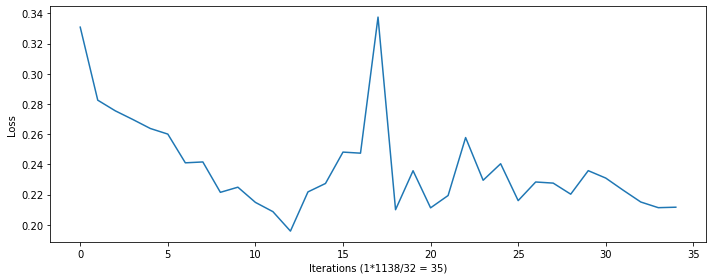

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_loss)
ax.set_ylabel('Loss')
ax.set_xlabel(f'Iterations ({n_epochs}*{len(combined_data)}/32 = {n_epochs*int(len(combined_data)/32)})')
fig.tight_layout()
plt.show()

In [30]:
model = model.eval()
test_data = torch.utils.data.DataLoader(project_data_converted['train'], batch_size=4)

In [36]:
def validate(test_data, model, device, num_labels):
    validation_results = []
    for i, batch in enumerate(tqdmn(test_data)):
        with torch.no_grad():
            batch = { k: v.to(device) for k, v in batch.items() }
            outputs = model(**batch)
        s_lengths = batch['attention_mask'].sum(dim=1)
        for idx, length in enumerate(s_lengths):
            true_values = batch['labels'][idx][:length]
            pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
            for true, pred in zip(true_values, pred_values):
                validation_results.append((true.item(), pred.item()))
    return validation_results


def count_validation_results(validation_results, null_element=0):
    confusion = torch.zeros(num_labels, num_labels)
    found = 0
    missed = 0
    wrong = 0
    for true, pred in validation_results:
        confusion[true][pred] += 1
        if true != null_element:
            if pred == true:
                found += 1
            else: 
                missed += 1
        elif pred != null_element:
            wrong += 1
    return confusion, found, missed, wrong

In [32]:
def read_model(directory):
    model = RobertaForTokenClassification.from_pretrained(roberta_version, num_labels=num_labels)
    model.config.id2label = id2label
    model.config.label2id = label2id
    model.train().to(device)
    model.from_pretrained(directory)
    model = model.eval()
    return model

#model = read_model("models/20211025_0")
#confusion, found, missed, wrong = validate(test_data, model, device, num_labels)

In [37]:
validation_results = validate(test_data, model, device, num_labels)

In [38]:
confusion, found, missed, wrong = count_validation_results(validation_results, null_element=1)

In [39]:
if found + wrong == 0:
    precision = 0.0
else:
    precision = found / (found + wrong)
recall = found / (found + missed)

print(f"precision: {precision:.3f}; recall: {recall:.3f}")

precision: 0.715; recall: 0.156


In [40]:
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

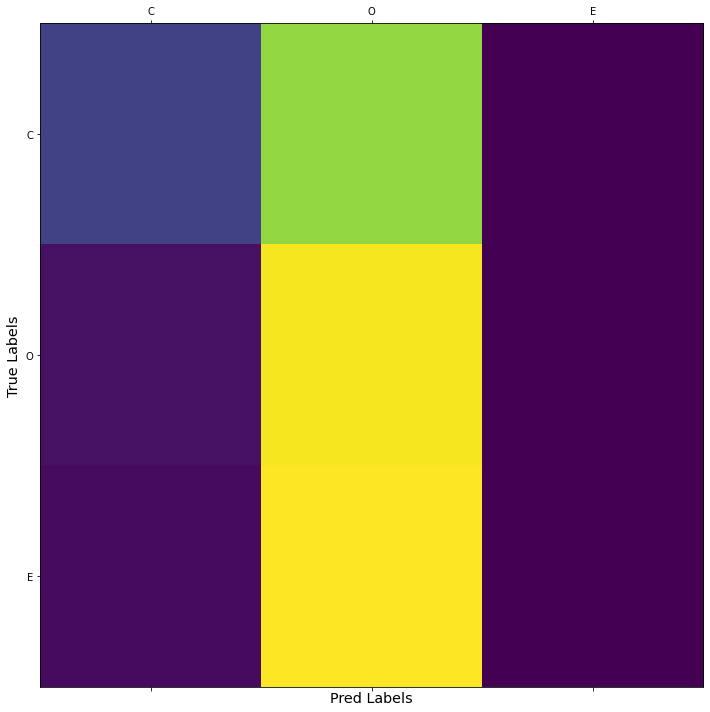

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confusion.numpy())

labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

ax.set_xticks(ids)
ax.set_xticklabels(labels)

ax.set_yticks(ids)
ax.set_yticklabels(labels)

fig.tight_layout()
plt.show()

In [42]:
confusion.numpy()

array([[0.18631984, 0.8136802 , 0.        ],
       [0.04313141, 0.9568686 , 0.        ],
       [0.02898551, 0.9710145 , 0.        ]], dtype=float32)

## 7. Visualize BERT output

In [67]:
len(validation_results)

45362

In [69]:
validation_results[0:32]

[(0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 1),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 0),
 (0, 0)]

In [64]:
for i in range(0, len(project_data["tokens"][0])):
    print(project_data["ner_tags"][0][i], project_data["tokens"][0][i])

0 You
0 ,
0 in
0 Greece
0 ,
0 with
0 our
0 support
0 ,
0 need
0 to
0 rebuild
0 your
0 country
1 ,
1 your
1 structures
1 ,
1 your
1 administration
1 ,
1 your
1 economy
2 to
0 increase
0 the
0 competitiveness
0 of
0 Greece
1 .


In [62]:
PAD_TOKEN = 1
example = project_data_converted["train"][0]

for i in range(0, len(example["input_ids"])):
    if example["input_ids"][i] != PAD_TOKEN:
        token = re.sub("^ *", "", tokenizer.decode(example["input_ids"][i:i+1]))
        label = example["labels"][i:i+1].item()
        print(label, token)

0 <s>
0 You
0 ,
0 in
0 Greece
0 ,
0 with
0 our
0 support
0 ,
0 need
0 to
0 rebuild
0 your
1 country
1 ,
1 your
1 structures
1 ,
1 your
1 administration
1 ,
1 your
2 economy
0 to
0 increase
0 the
0 competitiveness
0 of
1 Greece
0 .
0 </s>


In [47]:
project_data_converted["train"][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

In [66]:
len([    0,   370,  2156,    11,  4644,  2156,    19,    84,   323,  2156,
           240,     7,  9648,   110,   247,  2156,   110,  6609,  2156,   110,
           942,  2156,   110,   866,     7,   712,     5, 17755,     9,  4644,
           479,     2,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1])

512

## 8. SemEval-2018 Task 7

Sources:

* info: https://competitions.codalab.org/competitions/17422#learn_the_details-subtasks
* data: https://lipn.univ-paris13.fr/~gabor/semeval2018task7/

In [1]:
import pandas as pd
import re
import stanza
from bs4 import BeautifulSoup

In [2]:
DATA_FILE = "../semeval.2018/subtask2/1.1.text.xml"

In [3]:
def guess_entity_positions(abstract_tag):
    abstract_text = abstract_tag.text
    start = 0
    entity_positions = []
    for entity in abstract_tag.findAll("entity"):
        while (start + len(entity.text) < len(abstract_text) and 
               abstract_text[start:start + len(entity.text)] != entity.text):
            start += 1
        if start + len(entity.text) < len(abstract_text):
            entity_positions.append((start, start + len(entity.text), entity["id"]))
            start += 1
    return entity_positions

In [4]:
def show_entities(abstract_tag, entity_positions):
    entity_positions.reverse()
    paragraph = str(abstract_tag.text)
    for entity in entity_positions:
        paragraph = paragraph[:entity[1]] + "\x1b[m" + paragraph[entity[1]:]
        paragraph = paragraph[:entity[0]] + "\x1b[1;31;47m" + paragraph[entity[0]:]
    print(paragraph)

In [5]:
infile = open(DATA_FILE, 'r')
 
xml_data = infile.read()
soup = BeautifulSoup(xml_data, 'lxml')
for text_tag in soup.findAll("text"):
    for abstract_tag in text_tag.findAll("abstract"):
        entity_positions = guess_entity_positions(abstract_tag)
        show_entities(abstract_tag, entity_positions)
    break

infile.close()

 Oral communication is ubiquitous and carries important information yet it is also time consuming to document. Given the development of storage media and networks one could just record and store a conversation for documentation. The question is, however, how an interesting information piece would be found in a large database . Traditional information retrieval techniques use a histogram of keywords as the document representation but oral communication may offer additional indices such as the time and place of the rejoinder and the attendance. An alternative index could be the activity such as discussing, planning, informing, story-telling, etc. This paper addresses the problem of the automatic detection of those activities in meeting situation and everyday rejoinders. Several extensions of this basic idea are being discussed and/or evaluated: Similar to activities one can define subsets of larger database and detect those automatically which is shown on a large database of TV shows . E

In [6]:
infile = open("../semeval.2018/subtask2/1.1.relations.txt", "r")
relations = []
for line in infile:
    parts = re.split("[,()]", line)
    if parts[3] == "\n":
        parts[3] = "NORMAL"
    relations.append((parts[1], parts[2], parts[0], parts[3]))
infile.close()

In [7]:
nlp = stanza.Pipeline('en')

2021-10-12 15:30:12 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-10-12 15:30:12 INFO: Use device: cpu
2021-10-12 15:30:12 INFO: Loading: tokenize
2021-10-12 15:30:12 INFO: Loading: pos
2021-10-12 15:30:12 INFO: Loading: lemma
2021-10-12 15:30:12 INFO: Loading: depparse
2021-10-12 15:30:13 INFO: Loading: sentiment
2021-10-12 15:30:13 INFO: Loading: ner
2021-10-12 15:30:14 INFO: Done loading processors!


In [14]:
sentence = "You, in Greece, with our support, need to rebuild your country, your structures, your administration, \
            your economy to increase the competitiveness of Greece."

doc = nlp(sentence)
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

id: 1	word: You	head id: 10	head: need	deprel: nsubj
id: 2	word: ,	head id: 1	head: You	deprel: punct
id: 3	word: in	head id: 4	head: Greece	deprel: case
id: 4	word: Greece	head id: 1	head: You	deprel: nmod
id: 5	word: ,	head id: 10	head: need	deprel: punct
id: 6	word: with	head id: 8	head: support	deprel: case
id: 7	word: our	head id: 8	head: support	deprel: nmod:poss
id: 8	word: support	head id: 10	head: need	deprel: obl
id: 9	word: ,	head id: 10	head: need	deprel: punct
id: 10	word: need	head id: 0	head: root	deprel: root
id: 11	word: to	head id: 12	head: rebuild	deprel: mark
id: 12	word: rebuild	head id: 10	head: need	deprel: xcomp
id: 13	word: your	head id: 14	head: country	deprel: nmod:poss
id: 14	word: country	head id: 12	head: rebuild	deprel: obj
id: 15	word: ,	head id: 17	head: structures	deprel: punct
id: 16	word: your	head id: 17	head: structures	deprel: nmod:poss
id: 17	word: structures	head id: 14	head: country	deprel: conj
id: 18	word: ,	head id: 20	head: administration	d

need - to - increase

In [15]:
sentence = "And the best hope of a return to growth and job creation is inside the euro area."
doc = nlp(sentence)
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

id: 1	word: And	head id: 17	head: area	deprel: cc
id: 2	word: the	head id: 4	head: hope	deprel: det
id: 3	word: best	head id: 4	head: hope	deprel: amod
id: 4	word: hope	head id: 17	head: area	deprel: nsubj
id: 5	word: of	head id: 7	head: return	deprel: case
id: 6	word: a	head id: 7	head: return	deprel: det
id: 7	word: return	head id: 4	head: hope	deprel: nmod
id: 8	word: to	head id: 9	head: growth	deprel: case
id: 9	word: growth	head id: 7	head: return	deprel: nmod
id: 10	word: and	head id: 12	head: creation	deprel: cc
id: 11	word: job	head id: 12	head: creation	deprel: compound
id: 12	word: creation	head id: 9	head: growth	deprel: conj
id: 13	word: is	head id: 17	head: area	deprel: cop
id: 14	word: inside	head id: 17	head: area	deprel: case
id: 15	word: the	head id: 17	head: area	deprel: det
id: 16	word: euro	head id: 17	head: area	deprel: amod
id: 17	word: area	head id: 0	head: root	deprel: root
id: 18	word: .	head id: 17	head: area	deprel: punct
